In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as figure
import japanize_matplotlib
from scipy.stats import norm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay, partial_dependence
import shap
#pdfで保存する
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
#脱ブタン塔のプロセスデータを読み込む
df = pd.read_csv('debutanizer_data.csv')

# 目的変数の測定時間を考慮
df['y'] = df['y'].shift(5)

#yがnanとなる期間のデータを削除
df = df.dropna()

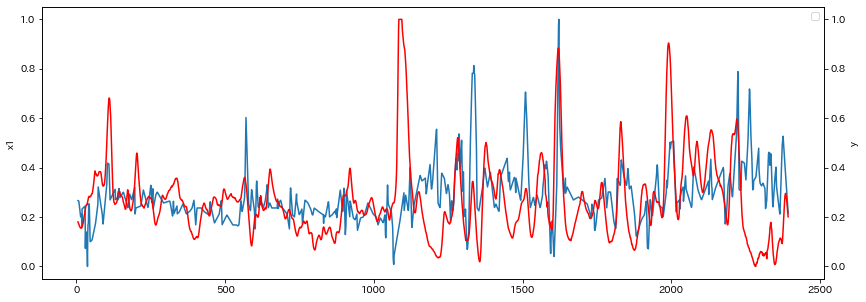

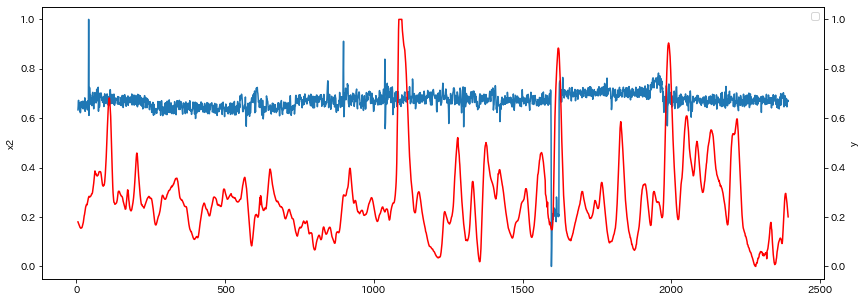

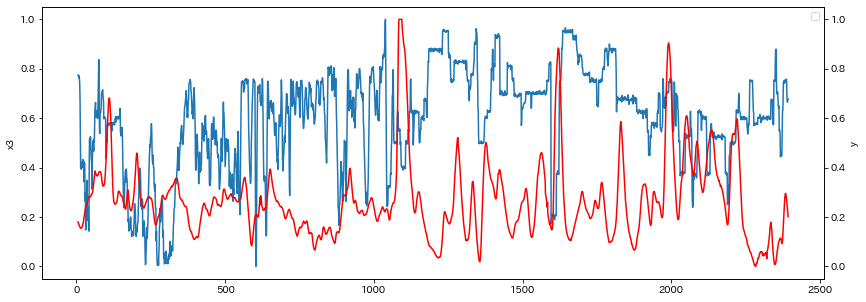

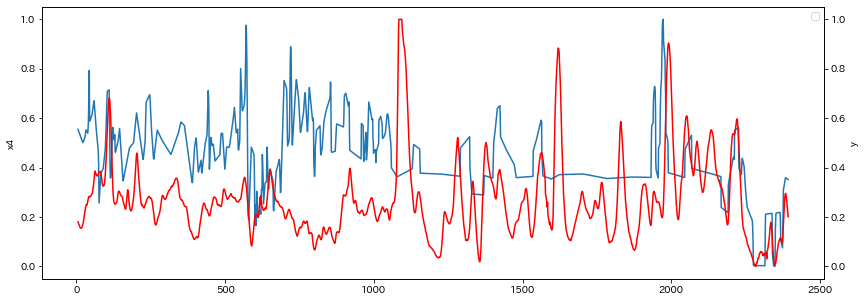

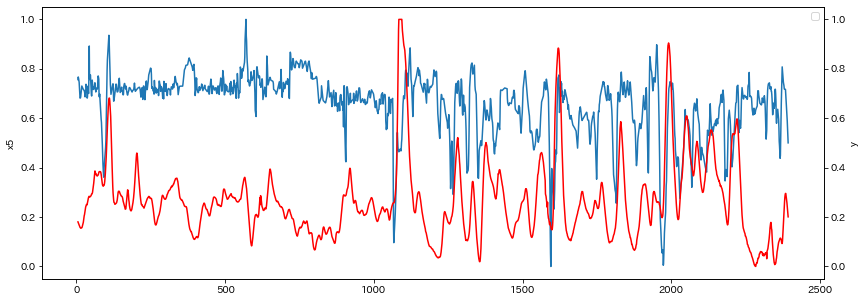

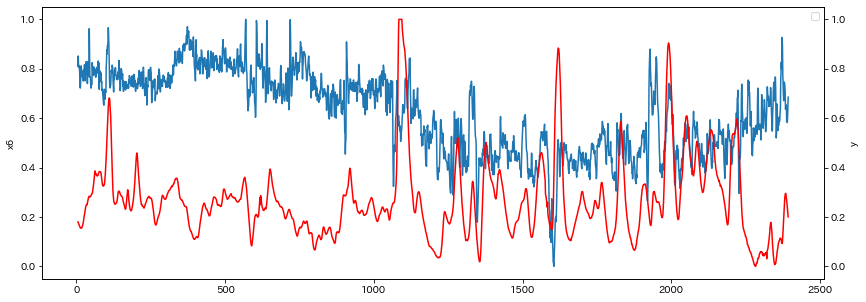

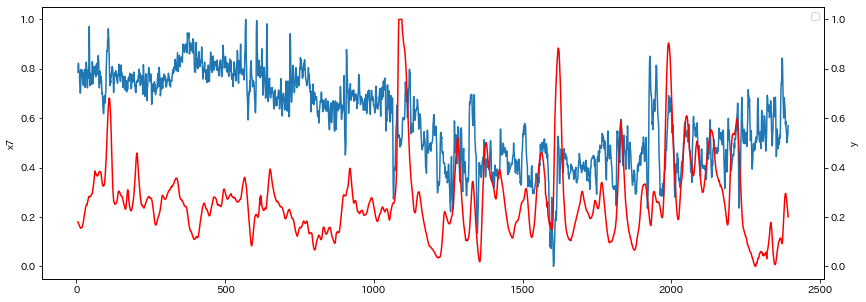

In [3]:
#pdfで保存するためpdfインスタンスを作成
pdf = PdfPages('trend_debutanizer.pdf')

#トレンドデータを可視化
for col in df.columns:
    if col == 'y':
        continue
    else:
        fig, ax1 =plt.subplots(figsize=(14,5)) 
        ax2 = ax1.twinx()
        ax1.plot(df[col])
        ax1.set_ylabel(col)
        ax2.plot(df['y'], color='red')
        ax2.set_ylabel('y')
        plt.grid(False)
        h1, l1 = ax1.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1+h2, l1+l2, loc='best')
        plt.show()
        # グラフを保存
        fig.savefig(f'{col}_trend.png', dpi=150)
        pdf.savefig(fig)
        plt.close(fig)
#close処理
pdf.close() 

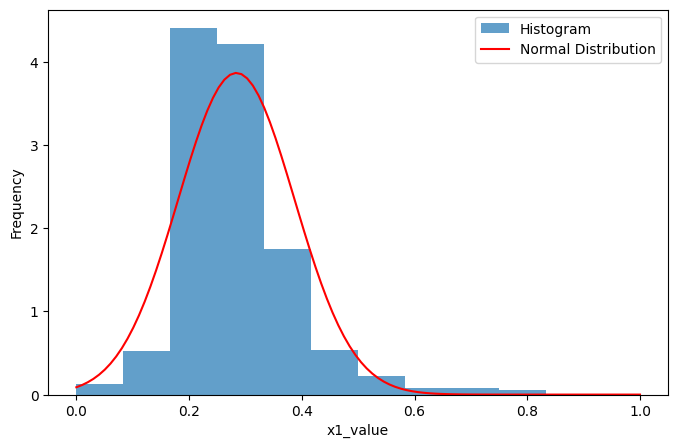

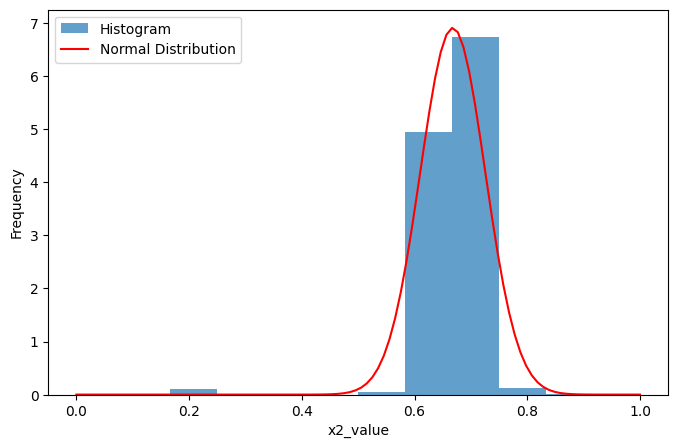

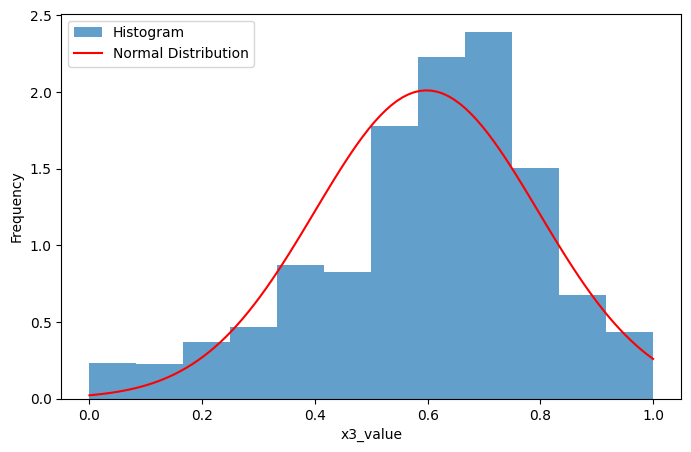

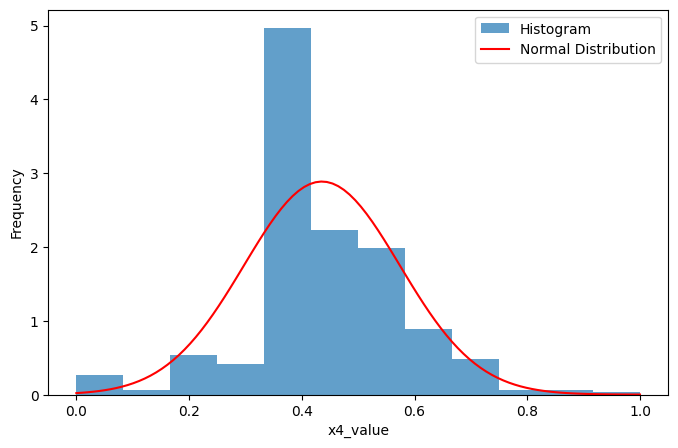

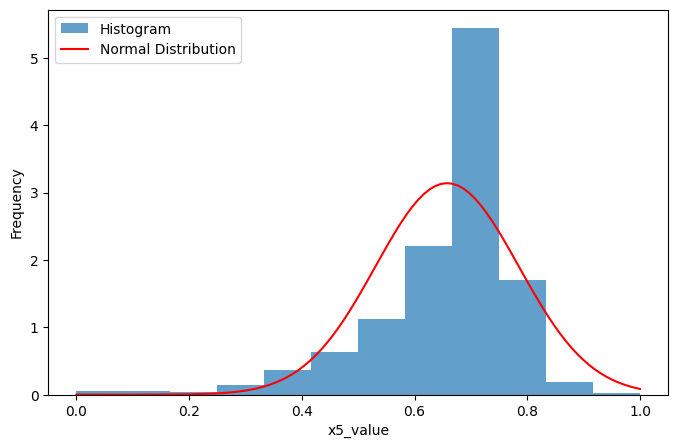

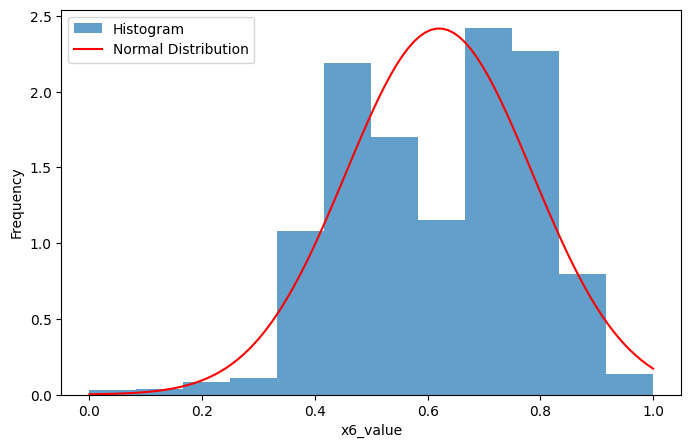

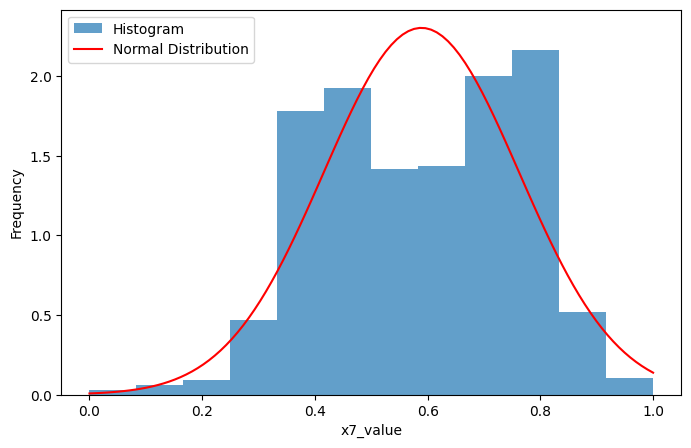

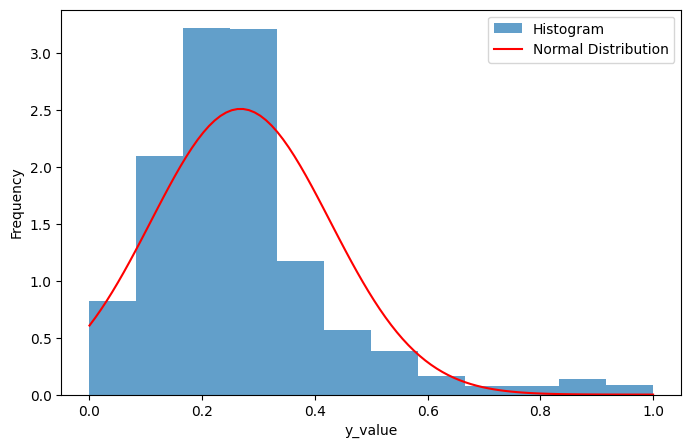

In [4]:
#pdfで保存するためpdfインスタンスを作成
pdf = PdfPages('histogram_debutanizer.pdf')

# 列ごとにヒストグラムを作成
for col in df.columns:
    # スタイルを変更（背景色を白、軸名の色を黒に設定）
    plt.style.use('default')
    # グラフの設定
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # ヒストグラムのbinの数を計算（スタージェスの公式）
    num_bins = int(np.log2(df[col].shape[0]) + 1)
    # ヒストグラムの表示(density=Trueで密度表示)
    ax.hist(df[col], bins=num_bins, density=True, alpha=0.7, label='Histogram')
    # 正規分布のパラメータの推定
    mu, sigma = norm.fit(df[col])
    # 正規分布曲線のx値の範囲を決定
    x = np.linspace(df[col].min(), df[col].max(), 100)
    # 正規分布曲線の描画
    ax.plot(x, norm.pdf(x, mu, sigma), 'r-', label='Normal Distribution')
    ax.set_xlabel(f'{col}_value')
    ax.set_ylabel('Frequency')
    ax.legend()
    plt.show()
    # グラフを保存
    fig.savefig(f'{col}_histogram_sturges.png', dpi=200)
    pdf.savefig(fig)
    plt.close(fig)
#close処理
pdf.close() 

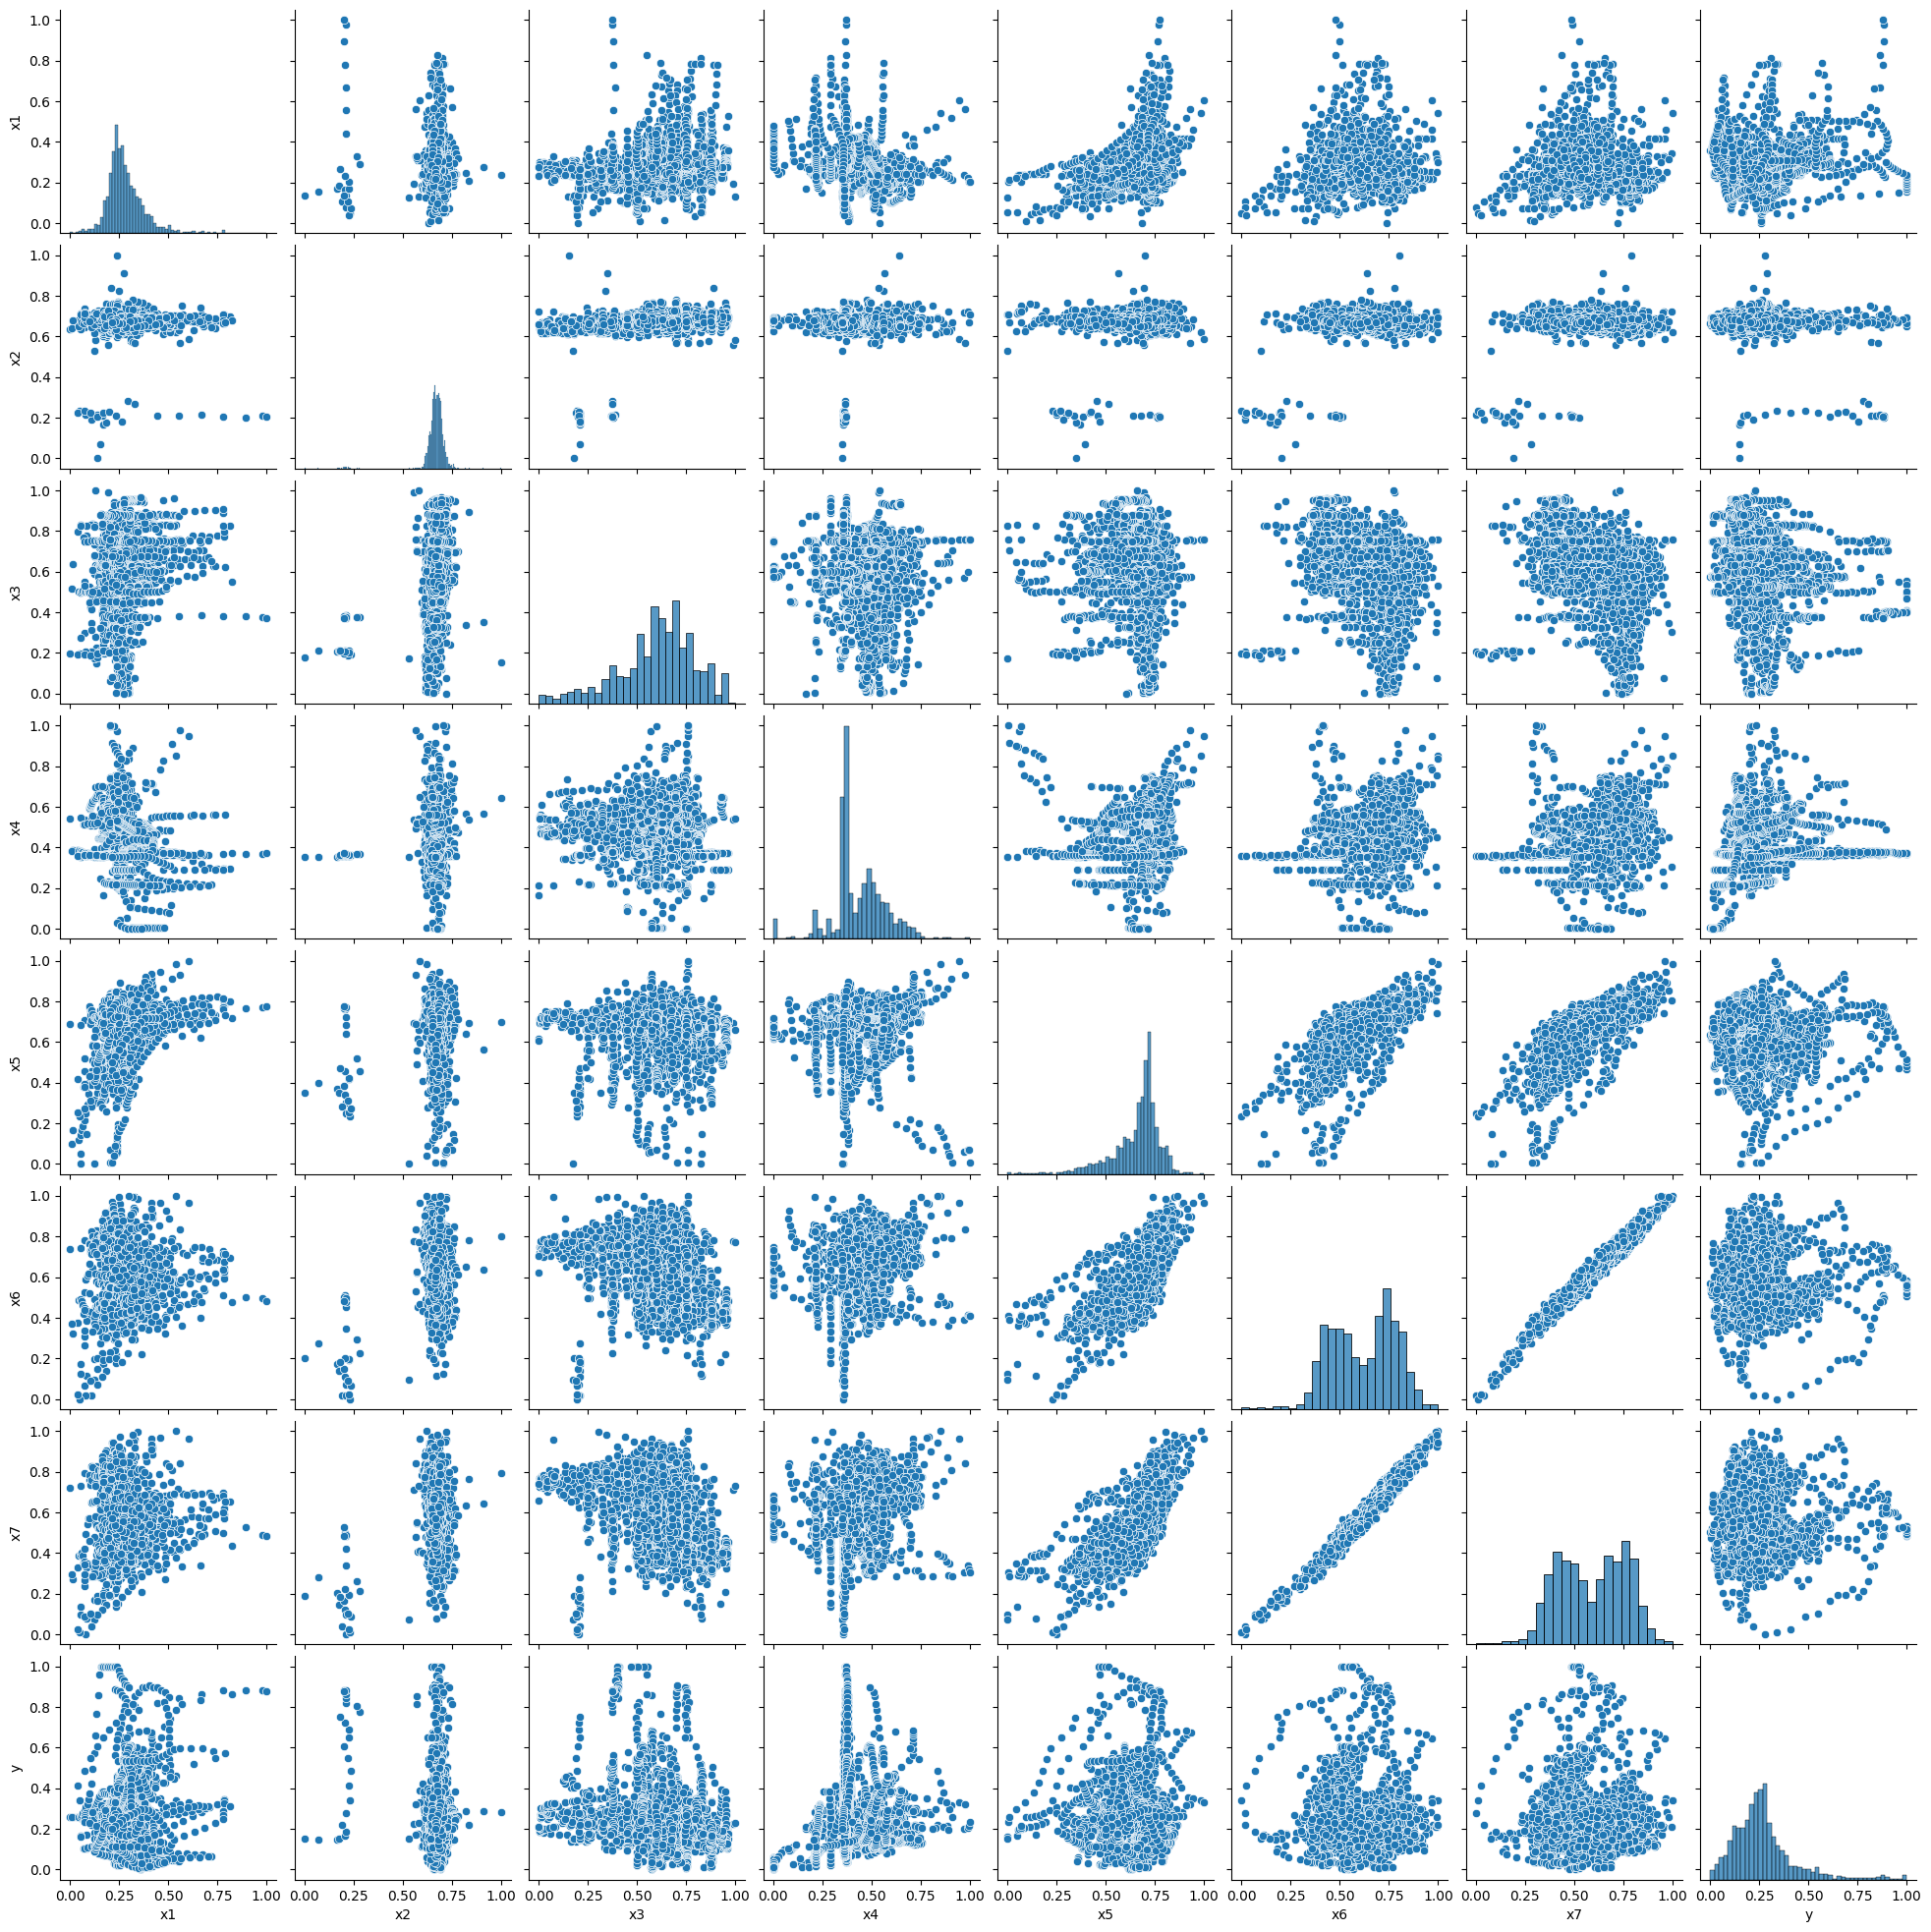

In [5]:
#各変数同士の散布図を確認
sns.pairplot(df)
plt.savefig('pairplot_debutanizer.png', dpi=150)

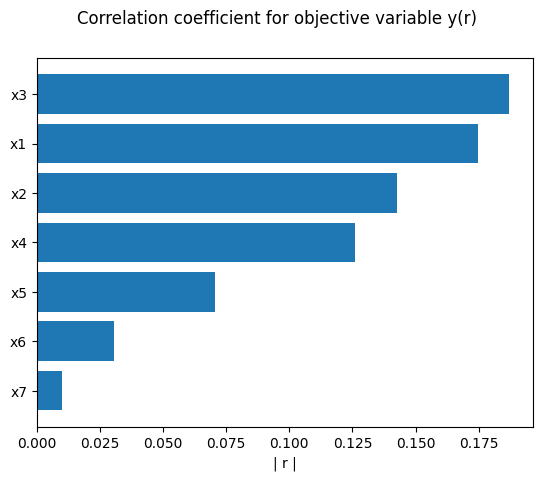

In [6]:
#相関行列を確認
df_corr = df.corr()
df_corr.to_csv('df_corr_debutanizer.csv')

#yに対する相関係数をグラフ化
df_corr_sort = abs(df_corr).sort_values('y')
fig, ax = plt.subplots()
ax.barh(df_corr_sort.index[:-1], df_corr_sort['y'][:-1])
ax.set(xlabel='| r |')
fig.suptitle('Correlation coefficient for objective variable y(r)')
fig.savefig('correlation_debutanizer.png', dpi=150)

In [7]:
#説明変数と目的変数にわける
X = df.iloc[:, :-1]
y = df['y']

#時間遅れ変数を作成
delay_number = 18
X_with_delays = pd.DataFrame()
for col in X.columns:
    col_name = f"{col}_delay_{delay_number}"
    X_with_delays[col_name] = X[col].shift(delay_number)

# 時間遅れ変数とｙのデータフレームを作成
X_with_delays['y'] = y
X_with_delays = X_with_delays.dropna()

# 目的変数と説明変数に分割
y = X_with_delays['y']
X = X_with_delays.iloc[:, :-1]

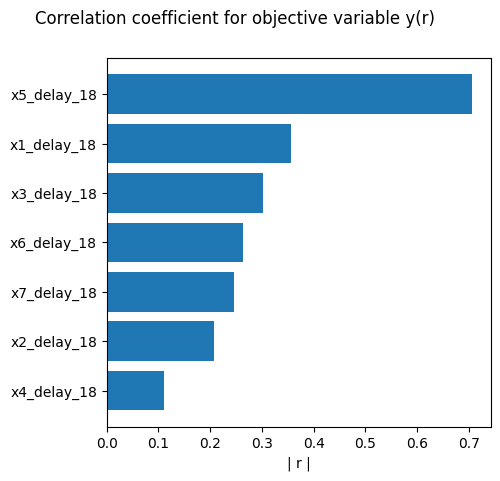

In [8]:
# 時間遅れ変数を含むデータフレームの相関行列を計算
X_with_delays_corr = X_with_delays.corr()

# 相関行列をCSVファイルに保存
X_with_delays_corr.to_csv('X_with_delays_corr_debutanizer.csv')

# yに対する相関係数をグラフ化
X_with_delays_corr_sort = abs(X_with_delays_corr).sort_values('y')
fig, ax = plt.subplots()
ax.barh(X_with_delays_corr_sort.index[:-1], X_with_delays_corr_sort['y'][:-1])
ax.set(xlabel='| r |')
fig.suptitle('Correlation coefficient for objective variable y(r)')

# 左側にスペースを空ける
plt.subplots_adjust(left=0.3)

# グラフを保存
fig.savefig('delays_correlation_debutanizer.png', dpi=150)

In [9]:
#学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

#ランダムフォレスト
rf = RandomForestRegressor(n_estimators=300, max_depth=5, max_features=0.8, random_state=42)

#ランダムフォレストのモデルを作成
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=0.8, n_estimators=300,
                      random_state=42)

In [10]:
# 学習データのおける予測値を算出
y_train_pred_rf = rf.predict(X_train)

# 評価指標の出力（RMSE、R2）
train_rmse = mean_squared_error(y_train, y_train_pred_rf, squared=False)
train_r2 = r2_score(y_train, y_train_pred_rf)
print(f'RMSE(学習):{train_rmse}')
print(f'R2(学習):{train_r2}')

# テストデータのおける予測値を算出
y_test_pred_rf = rf.predict(X_test)

# 評価指標の出力（RMSE、R2）
test_rmse = mean_squared_error(y_test, y_test_pred_rf, squared=False)
test_r2 = r2_score(y_test, y_test_pred_rf)
print(f'RMSE(テスト):{test_rmse}')
print(f'R2(テスト):{test_r2}')

# RMSEとR2をエクセルファイルに保存
results_df = pd.DataFrame({'RMSE': [train_rmse, test_rmse], 'R2': [train_r2, test_r2]}, index=['Train', 'Test'])
results_df.to_csv('results.csv')

RMSE(学習):0.057327958388528465
R2(学習):0.8352733514446198
RMSE(テスト):0.1265336602742375
R2(テスト):0.5200333705878986


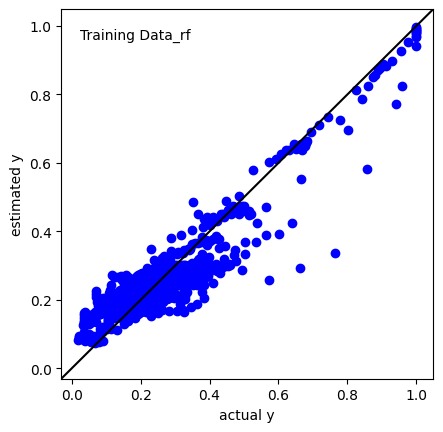

In [11]:
# 実測値 vs. 推定値のプロット（学習データ）
plt.figure(figsize=figure.figaspect(1)) 
plt.scatter(y_train, y_train_pred_rf, c='blue')  # 実測値 vs. 推定値プロット

# 実測値と推定値の最大値・最小値を取得
y_max = max(y_train.max(), y_train_pred_rf.max())
y_min = min(y_train.min(), y_train_pred_rf.min())

# 対角線を作成
margin = 0.05 * (y_max - y_min)  # 対角線の端点を、最大値・最小値から5%ずつ離す
plt.plot([y_min - margin, y_max + margin], [y_min - margin, y_max + margin], 'k-')

# x 軸・y 軸の範囲を設定
plt.ylim(y_min - margin, y_max + margin)
plt.xlim(y_min - margin, y_max + margin)

# x 軸・y 軸の名前を設定
plt.xlabel('actual y')
plt.ylabel('estimated y')

# グラフ内にテキストを追加
plt.text(0.05, 0.95, 'Training Data_rf', ha='left', va='top', transform=plt.gca().transAxes)

# グラフをpng形式で保存
plt.savefig('actual_vs_estimated_train_rf.png', dpi=300)

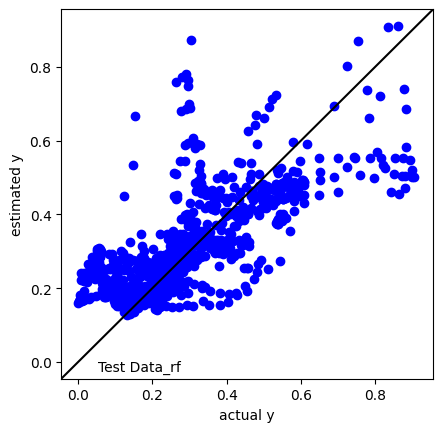

In [12]:
# 実測値 vs. 推定値のプロット（テストデータ）
plt.figure(figsize=figure.figaspect(1)) 
plt.scatter(y_test, y_test_pred_rf, c='blue')  # 実測値 vs. 推定値プロット

# 実測値と推定値の最大値・最小値を取得
y_max = max(y_test.max(), y_test_pred_rf.max())
y_min = min(y_test.min(), y_test_pred_rf.min())

# 対角線を作成
margin = 0.05 * (y_max - y_min)  # 対角線の端点を、最大値・最小値から5%ずつ離す
plt.plot([y_min - margin, y_max + margin], [y_min - margin, y_max + margin], 'k-')

# x 軸・y 軸の範囲を設定
plt.ylim(y_min - margin, y_max + margin)
plt.xlim(y_min - margin, y_max + margin)

# x 軸・y 軸の名前を設定
plt.xlabel('actual y')
plt.ylabel('estimated y')

# グラフ内にテキストを追加
plt.text(0.10, 0.05, 'Test Data_rf', ha='left', va='top', transform=plt.gca().transAxes)

# グラフをpng形式で保存
plt.savefig('actual_vs_estimated_test_rf.png', dpi=300)

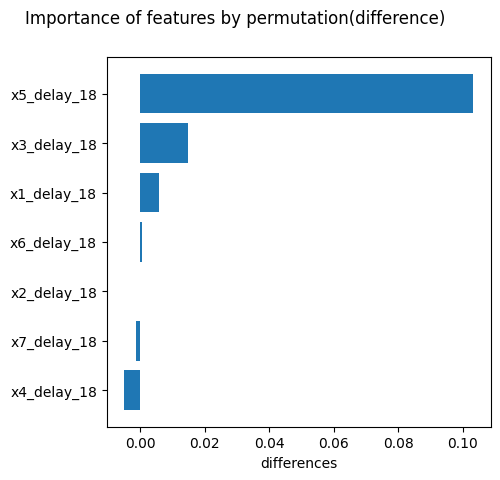

In [13]:
# 特徴量の重要度を確認（PFI）※テストデータ
pfi = permutation_importance(
    estimator=rf,
    X=X_test,
    y=y_test,
    scoring='neg_root_mean_squared_error',
    n_repeats=5,
    n_jobs=-1,
)

# テストデータのPFIをデータフレームに格納
df_pfi = pd.DataFrame(
    data={'var_name': X_test.columns, 'importance': pfi['importances_mean']}
).sort_values('importance')

# 特徴量の重要度（PFI）をグラフ化
fig, ax = plt.subplots()
ax.barh(df_pfi['var_name'], df_pfi['importance'])
ax.set(xlabel='differences')
fig.suptitle('Importance of features by permutation(difference)')

# 左側にスペースを空ける
plt.subplots_adjust(left=0.3)

# グラフを保存
fig.savefig('PFI_graph_debutanaizer.png', dpi=150)

In [14]:
# 特徴量の重要度（PFI）が大きい上位4変数のPDをグラフ化
for col in df_pfi['var_name'][-4:]:
    fig, ax = plt.subplots(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        estimator=rf,
        X=X_test,
        features=[col],  # PDを計算したい特徴量
        kind="average",  # PDは"average", ICEは"individual"、両方は"both"
        ax=ax
    )
    fig.suptitle(f'{col}_Partial Dependence Plot')
    fig.savefig(f'{col}_PD_graph.png', dpi=150)
    plt.close(fig)

In [15]:
# 特徴量の重要度（PFI）が大きい上位4変数のICEを可視化
for col in df_pfi['var_name'][-4:]:
    fig, ax = plt.subplots(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        estimator=rf,
        X=X_test,
        features=[col],  # PDを計算したい特徴量
        kind="both",  # PDは"average", ICEは"individual"、両方は"both"
        ax=ax
    )
    fig.suptitle(f'{col}_ICE Plot')
    # グラフをpngファイルに保存
    fig.savefig(f'{col}_ICE_graph.png', dpi=150)
    plt.close(fig)

In [16]:
#SHAPを計算する
explainer = shap.TreeExplainer(
    model=rf,
    data=X_test,
    feature_perturbation='interventional',#推奨
    #check_additivity=False # 加法性チェックを無効にする
)
shap_values = explainer(X_test)

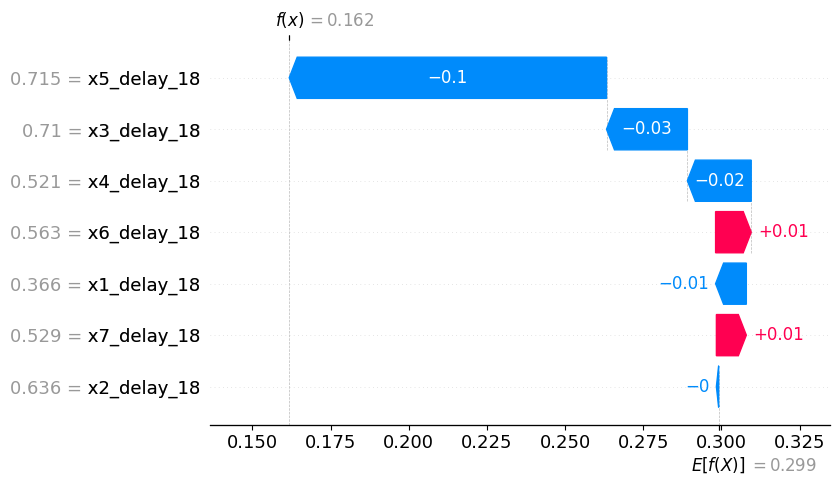

In [17]:
shap.plots.waterfall(shap_values[0])

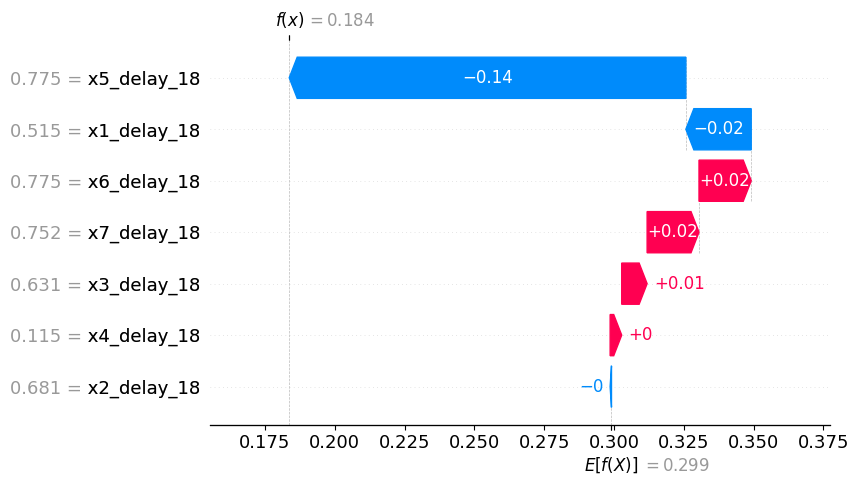

In [18]:
shap.plots.waterfall(shap_values[-1])

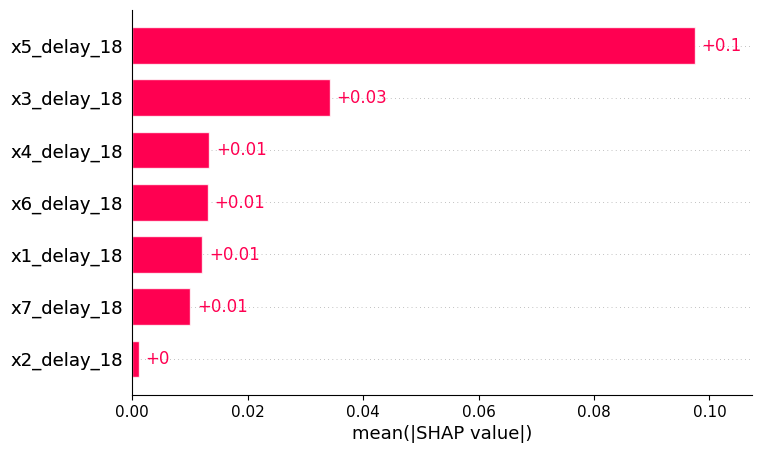

In [19]:
shap.plots.bar(shap_values)

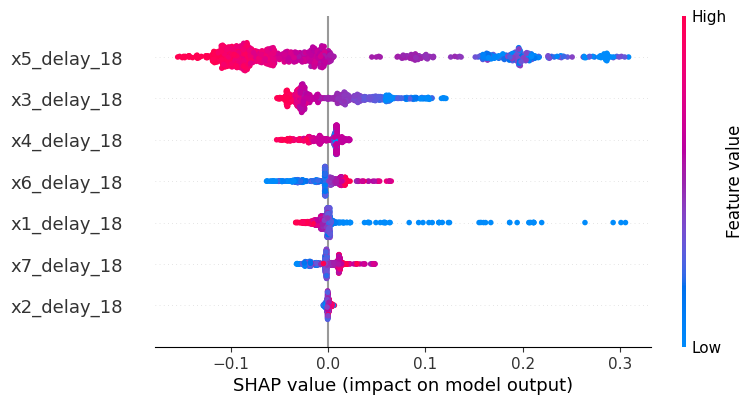

In [20]:
shap.plots.beeswarm(shap_values)

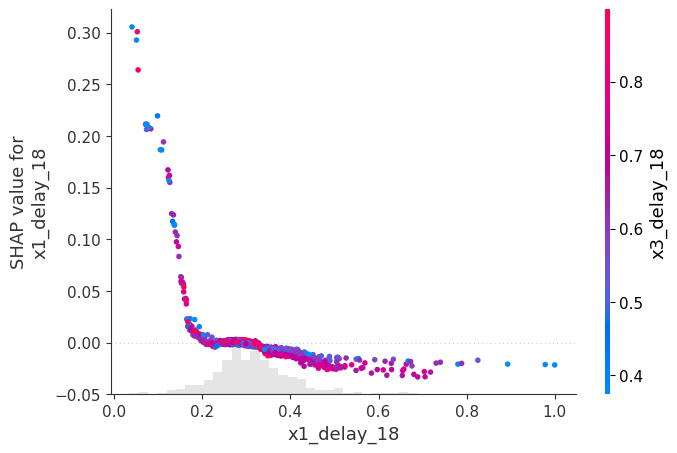

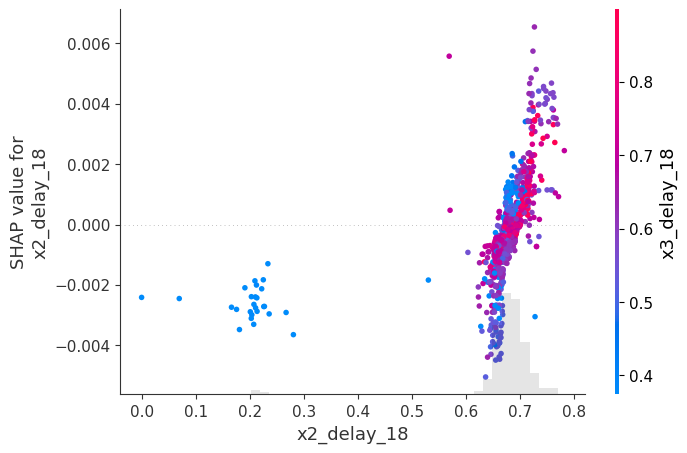

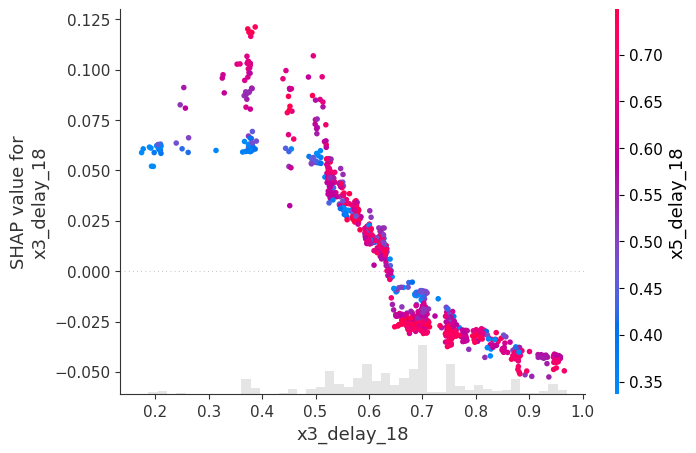

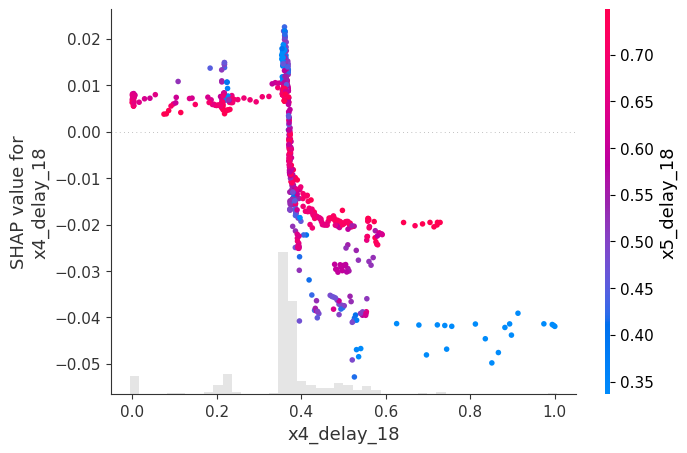

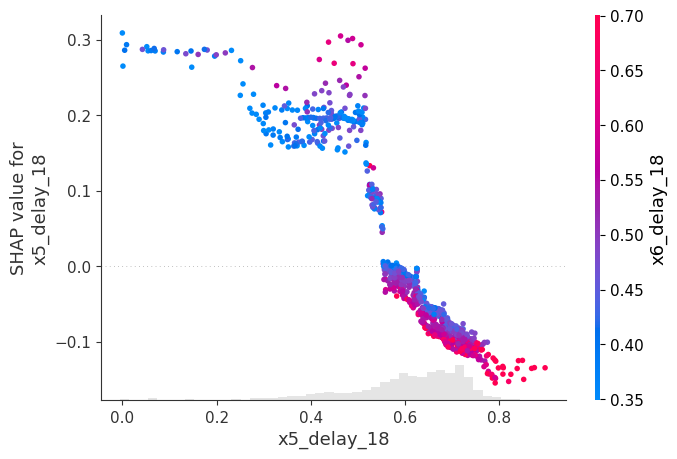

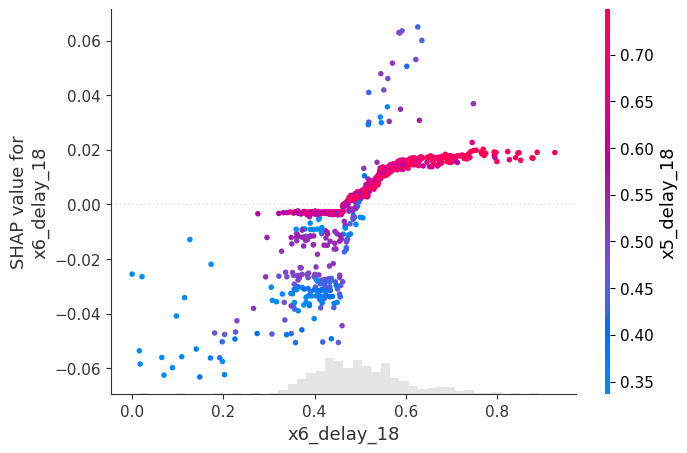

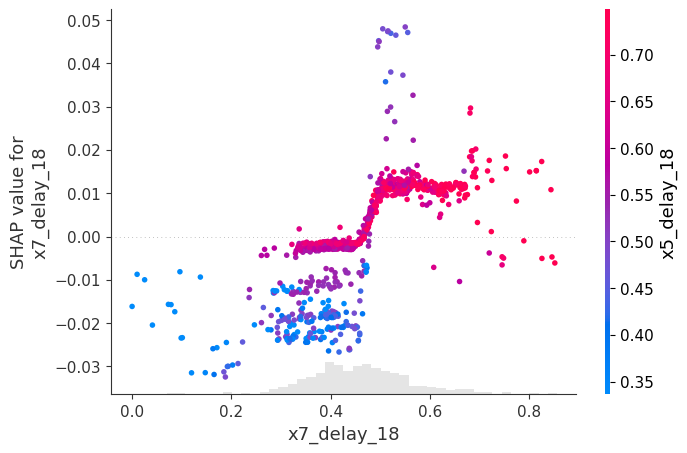

In [21]:
for col in X.columns:
    shap.plots.scatter(shap_values[:, col], color=shap_values)